### Imports

In [9]:
import psycopg2
import pandas as pd
import sys
import copy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
from scipy.stats import kde

sns.set_style("whitegrid", {'axes.grid' : False})

### Functions to query the databases

In [10]:
# create connection
def get_db_handle(dbname="testdb", rolename ="spotify"):
    con = None
    constr = "host='localhost' dbname='"+dbname+"'  user='"+rolename+"' password='ics'"
    try:
        con = psycopg2.connect(constr)
    except Exception as e:
        if con: 
            con.rollback()
        print('Error creating or connecting handle', str(e))
        sys.exit(1)
    if con is None:
        print('Error creating handle', str(e))
        sys.exit(1)
    return con

In [11]:
# open a cursor and fetch db to a pandas dataframe
def query_db_translate_to_pandas(con, querystring):
    df = None
    try:
        cur = con.cursor()
        df = pd.read_sql(querystring, con)
    except Exception as e:
        con.rollback() # meaning break the connection safely
        print("Error in printing table", str(e))
    return df

In [12]:
def close_db(handle1):
    if handle1:
        handle1.close()
    return

### Get data from Alltracks 

In [13]:
con = get_db_handle()
print(con)
querystr = "select * from alltracks"
#  querystr = "select id, name, from alltracks"
#where name like \'%Shri%\'"
df = query_db_translate_to_pandas(con, querystr)
print(df.shape)
#   print(df.to_string())

<connection object at 0x110e3cbd0; dsn: 'user=spotify password=xxx dbname=testdb host=localhost', closed: 0>
(11044, 12)


### Get data from Ragafeaturedb

In [14]:
con = get_db_handle()
#     print(con)
querystr = "select * from ragafeaturedb"
    #where name like \'%Shri%\'"
df = query_db_translate_to_pandas(con, querystr)
#     print(df.to_string())
print(df.columns)
# print(df.sp_key)
# print(df.shape)

Index(['id', 'name', 'url', 'sp_danceability', 'sp_energy', 'sp_key',
       'sp_loudness', 'sp_mode', 'sp_speechiness', 'sp_acousticness',
       'sp_instrumentalness', 'sp_liveness', 'sp_valence', 'sp_tempo',
       'gn_gnid', 'gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1',
       'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3'],
      dtype='object')


In [15]:
df.sp_energy = df.sp_energy.astype('float64')
df.sp_valence = df.sp_valence.astype('float64')
data_peace = copy.deepcopy(df)
data_peace['mood_new'] = data_peace.gn_mood_1
# change the value of a column according to a conditional
data_peace.loc[data_peace.gn_mood_1 == 'Peaceful', 'mood_new'] = 'Peaceful'
data_peace.loc[data_peace.gn_mood_1 != 'Peaceful', 'mood_new'] = 'other'
print(data_peace.columns)

Index(['id', 'name', 'url', 'sp_danceability', 'sp_energy', 'sp_key',
       'sp_loudness', 'sp_mode', 'sp_speechiness', 'sp_acousticness',
       'sp_instrumentalness', 'sp_liveness', 'sp_valence', 'sp_tempo',
       'gn_gnid', 'gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1',
       'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3', 'mood_new'],
      dtype='object')


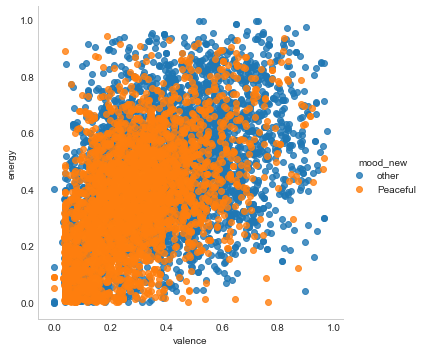

In [17]:
sns.lmplot(x = 'sp_valence', y = 'sp_energy', 
           hue = 'mood_new', fit_reg = False, data = data_peace, 
           hue_order=['other', 'Peaceful'])
plt.xlabel('valence')
plt.ylabel('energy')
# plt.tight_layout()
plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week3/PeaceSP.jpg', dpi = 300)

### Distribution of songs across primary GN mood labels

        gn_mood_1    id
0           Rowdy     3
1         Defiant     4
2         Excited     6
3          Upbeat    11
4            Cool    11
5      Energizing    12
6      Aggressive    13
7      Empowering    23
8          Urgent    25
9          Tender    30
10       Yearning    36
11         Lively    39
12       Stirring    47
13       Brooding    49
14        Sensual    66
15  Sophisticated    91
16     Melancholy    97
17    Sentimental   100
18       Romantic   134
19      Easygoing   148
20         Gritty   157
21          Fiery   536
22         Somber   556
23        Serious  1817
24       Peaceful  3104
        gn_mood_1         id
24       Peaceful  43.626142
23        Serious  25.537597
22         Somber   7.814476
21          Fiery   7.533380
20         Gritty   2.206606
19      Easygoing   2.080112
18       Romantic   1.883345
17    Sentimental   1.405481
16     Melancholy   1.363317
15  Sophisticated   1.278988
14        Sensual   0.927618
13       Brooding   0.688686

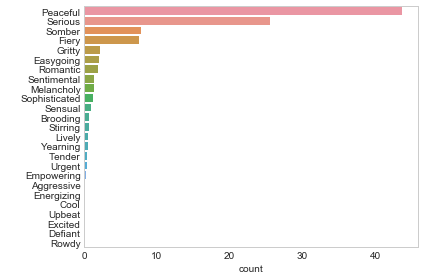

In [18]:
# Peaceful is most prominent mood
df_dist = df[['id', 'gn_mood_1']].groupby(['gn_mood_1']).aggregate('count').sort_values('id').reset_index()
print(df_dist)
df_dist = df_dist.sort_values('id', ascending= False)
df_dist['id'] = df_dist['id']/(df_dist['id'].sum())*100
print(df_dist)
ax = sns.barplot(x = 'id', y = 'gn_mood_1', data = df_dist)
# plt.xticks(rotation=90);
percentage = []
for x in df_dist['id'].as_matrix():
    percentage.append(x*100/(np.sum(df_dist['id'].as_matrix())))
print(percentage)
plt.xlabel('percentage')
plt.ylabel(" ")
plt.xlabel('count')
plt.tight_layout()
plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week3/GNsongDistr.jpg', dpi = 300)

In [19]:
# get mood labels from gracenote
mood_1 = df.gn_mood_1.unique().tolist()
print(mood_1)
mood_2 = df.gn_mood_2.unique().tolist()
print(mood_2)
print(len(mood_1), len(mood_2))

['Peaceful', 'Sophisticated', 'Serious', 'Fiery', 'Stirring', 'Melancholy', 'Somber', 'Lively', 'Brooding', 'Romantic', 'Gritty', 'Sentimental', 'Easygoing', 'Defiant', 'Empowering', 'Upbeat', 'Sensual', 'Yearning', 'Energizing', 'Urgent', 'Tender', 'Aggressive', 'Cool', 'Rowdy', 'Excited']
['Quiet / Introspective', 'Dark Playful', 'Serious / Cerebral', 'Hypnotic Rhythm', 'Dark Sparkling Lyrical', 'Focused Sparkling', 'Light Melancholy', 'Wistful / Forlorn', 'Solemn / Spiritual', 'Intimate Bittersweet', 'Creepy / Ominous', 'Exuberant / Festive', 'Alienated / Brooding', 'Heartfelt Passion', 'Gritty / Soulful', 'Cool Melancholy', 'Charming / Easygoing', 'Depressed / Lonely', 'Heavy Brooding', 'Fiery Groove', 'Dramatic Emotion', 'Evocative / Intriguing', 'Cheerful / Playful', 'Soulful / Easygoing', 'Smoky / Romantic', 'Lush / Romantic', 'Showy / Rousing', 'Dreamy Pulse', 'Delicate / Tranquil', 'Sensitive / Exploring', 'Passionate Rhythm', 'Arousing Groove', 'Friendly', 'Soft Soulful', 'Th

## Plot a heat-map of gracenote mood_1 vs mood_2

84


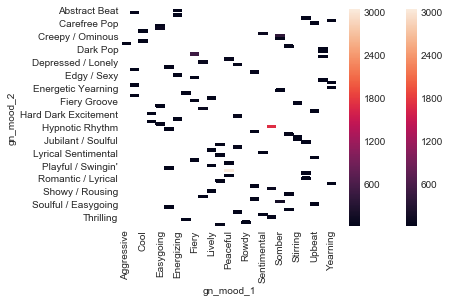

In [20]:
### make a new df that has rows as mood_1 and colums as mood_2 and value as the number of times the combination appeared
# get count of each of 2500 emotions
df_m1m2 = df
df_m1m2 = df_m1m2[['id','gn_mood_1', 'gn_mood_2']].groupby(['gn_mood_1', 'gn_mood_2']).agg(['count']).reset_index()

#print(df_m1m2.to_string())
#print(df_m1m2['id'])
#print(type(df_m1m2['id']))
#print(df_m1m2['id']['count'])
frames = [df_m1m2['gn_mood_1'], df_m1m2['gn_mood_2'], df_m1m2['id']['count']]
result = pd.concat(frames, axis=1)

# df_nw = pd.DataFrame()
# df_nw.loc['gn_mood_1'] = df_m1m2.loc['gn_mood_1']

df_hm = result.pivot("gn_mood_2", "gn_mood_1", "count")
ax = sns.heatmap(df_hm)
ax = sns.heatmap(df_hm)

print(result['count'].astype(bool).sum(axis=0))

## Digging into peaceful

In [21]:
# create a dataframe to store all mean valence energy values
df_mean_values = pd.DataFrame()
df_mean_values['mood_1'] = mood_1
df_mean_values['mean_valence'] = 0
df_mean_values['mean_energy'] = 0
df_mean_values.to_string

<bound method DataFrame.to_string of            mood_1  mean_valence  mean_energy
0        Peaceful             0            0
1   Sophisticated             0            0
2         Serious             0            0
3           Fiery             0            0
4        Stirring             0            0
5      Melancholy             0            0
6          Somber             0            0
7          Lively             0            0
8        Brooding             0            0
9        Romantic             0            0
10         Gritty             0            0
11    Sentimental             0            0
12      Easygoing             0            0
13        Defiant             0            0
14     Empowering             0            0
15         Upbeat             0            0
16        Sensual             0            0
17       Yearning             0            0
18     Energizing             0            0
19         Urgent             0            0
20         Tender 

In [22]:
# create a dataframe with songs that are classified as peaceful by GN
df_peaceful = df[df['gn_mood_1']=='Peaceful']

In [23]:
# df_notpeaceful.dtypes;
df_peaceful.dtypes;

In [24]:
# convert values to float
# df_notpeaceful_sp = df_notpeaceful
df_peaceful_sp    = df_peaceful
# df_notpeaceful_sp = df_notpeaceful_sp[['sp_valence', 'sp_energy']].astype('float64')
df_peaceful_sp    = df_peaceful_sp[['sp_valence', 'sp_energy']].astype('float64')

Valence mean:  0.2837574420103085
Energy mean:  0.36260423646907214


Text(0.5,37.5,'Valence')

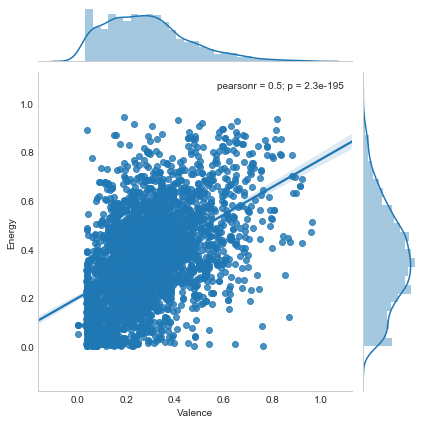

In [25]:
sns.jointplot(x='sp_valence', y='sp_energy', data=df_peaceful_sp, kind ='reg')
print("Valence mean: ", df_peaceful_sp['sp_valence'].mean())
df_mean_values.loc['Peaceful','mean_valence'] = df_peaceful_sp['sp_valence'].mean()
df_mean_values.loc['Peaceful','mean_energy'] = df_peaceful_sp['sp_energy'].mean()
print("Energy mean: ", df_peaceful_sp['sp_energy'].mean())
ax = plt.gca()
plt.ylabel('Energy')
plt.xlabel('Valence')
# ax.set_title("Peaceful")
# (0.95, 0.5) = desired

## Digging into serious

Valence mean:  0.3892563566318112
Energy mean:  0.4493356466703363


Text(0.5,1,'Serious')

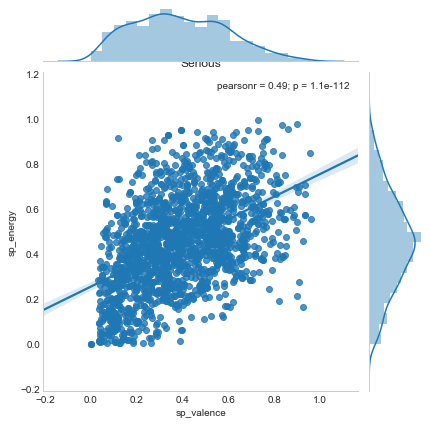

In [28]:
# create a dataframe with songs that are not classified as peaceful by GN
# create a dataframe with songs that are classified as peaceful by GN
df_serious = df[df['gn_mood_1']=='Serious']

# convert values to float
df_serious_sp    = df_serious
df_serious_sp    = df_serious_sp[['sp_valence', 'sp_energy']].astype('float64')

sns.jointplot(x='sp_valence', y='sp_energy', data=df_serious_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_serious_sp['sp_valence'].mean())
df_mean_values.loc['Serious','mean_valence'] = df_serious_sp['sp_valence'].mean()
df_mean_values.loc['Serious','mean_energy'] = df_serious_sp['sp_energy'].mean()
print("Energy mean: ", df_serious_sp['sp_energy'].mean())
ax.set_title("Serious")

## Digging into Sophisticated

Valence mean:  0.3929593406593407
Energy mean:  0.4908571428571427


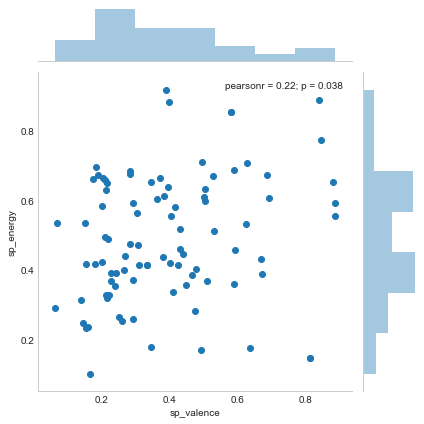

In [29]:
# create a dataframe with songs that are not classified as peaceful by GN
# create a dataframe with songs that are classified as peaceful by GN
df_sophisticated = df[df['gn_mood_1']=='Sophisticated']

# convert values to float
df_sophisticated_sp    = df_sophisticated
df_sophisticated_sp    = df_sophisticated_sp[['sp_valence', 'sp_energy']].astype('float64')

sns.jointplot(x='sp_valence', y='sp_energy', data=df_sophisticated_sp)
ax = plt.gca()
print("Valence mean: ", df_sophisticated_sp['sp_valence'].mean())
df_mean_values.loc['Sophisticated','mean_valence'] = df_sophisticated_sp['sp_valence'].mean()
df_mean_values.loc['Sophisticated','mean_energy'] = df_sophisticated_sp['sp_energy'].mean()
print("Energy mean: ", df_sophisticated_sp['sp_energy'].mean())

## Digging into Lively

Valence mean:  0.5205897435897436
Energy mean:  0.6004358974358978


/Users/feelharmonic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/feelharmonic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


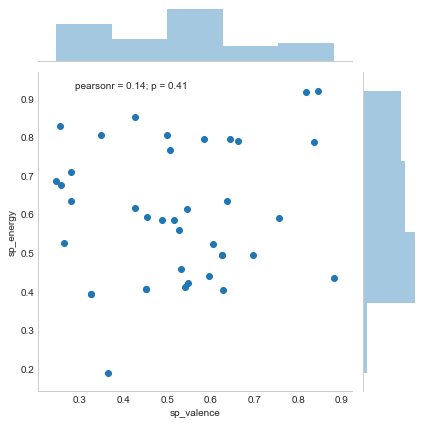

In [30]:
# create a dataframe with songs that are classified as peaceful by GN
df_lively = df[df['gn_mood_1']=='Lively']

# convert values to float
df_lively_sp           = df_lively
df_lively_sp           = df_lively_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_lively_sp)
ax = plt.gca()
print("Valence mean: ", df_lively_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Lively'] = df_lively_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Lively'] = df_lively_sp['sp_energy'].mean()
print("Energy mean: ", df_lively_sp['sp_energy'].mean())

## Digging into Romantic

Valence mean:  0.3322708955223878
Energy mean:  0.37908037313432835


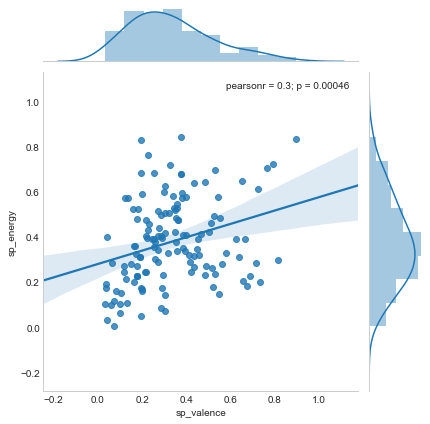

In [31]:
# create a dataframe with songs that are classified as peaceful by GN
df_romantic = df[df['gn_mood_1']=='Romantic']

# convert values to float
df_romantic_sp           = df_romantic
df_romantic_sp           = df_romantic_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_romantic_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_romantic_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Romantic'] = df_romantic_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Romantic'] = df_romantic_sp['sp_energy'].mean()
print("Energy mean: ", df_romantic_sp['sp_energy'].mean())
# ax.set_title("Romantic")

## Digging into Rowdy

                          id                                         name  \
3372  2ddV4ajaED9v5ZBdtdoI7n  Nidhi Chala Sukhama - Kalyani - Misra Chapu   
3373  0UNWb17h2A5ELjyyTJZhKW             Yaro Ivar Yaro - Bhairavi - Aadi   
3374  1YUHTnGPKohyAOkjFuTV4g            Thillana - Kapi Narayani - Rupaka   

                                                    url sp_danceability  \
3372  https://open.spotify.com/track/2ddV4ajaED9v5ZB...           0.355   
3373  https://open.spotify.com/track/0UNWb17h2A5ELjy...           0.512   
3374  https://open.spotify.com/track/1YUHTnGPKohyAOk...           0.292   

      sp_energy sp_key sp_loudness sp_mode sp_speechiness sp_acousticness  \
3372      0.916      9      -5.419       1           0.11           0.647   
3373      0.843     10      -6.359       1          0.154           0.754   
3374      0.747      9      -6.198       1         0.0861           0.817   

        ...     sp_tempo                                     gn_gnid  \
3372    .

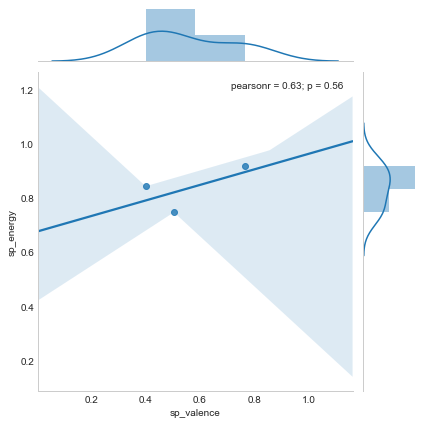

In [32]:
# create a dataframe with songs that are classified as peaceful by GN
df_rowdy = df[df['gn_mood_1']=='Rowdy']
print(df_rowdy)

# convert values to float
df_rowdy_sp           = df_rowdy
df_rowdy_sp           = df_rowdy_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_rowdy_sp, kind = 'reg')
ax = plt.gca()
print("Valence mean: ", df_serious_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Rowdy'] = df_rowdy_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Rowdy'] = df_rowdy_sp['sp_energy'].mean()
print("Energy mean: ", df_serious_sp['sp_energy'].mean())
# ax.set_title("Rowdy")

## Digging into Sensual

Valence mean:  0.36074393939393945
Energy mean:  0.4848939393939395


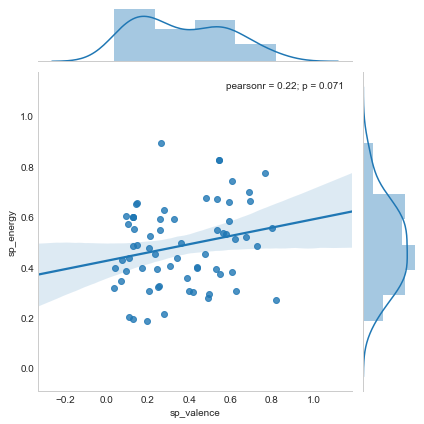

In [33]:
# create a dataframe with songs that are classified as peaceful by GN
df_sensual = df[df['gn_mood_1']=='Sensual']

# convert values to float
df_sensual_sp            = df_sensual
df_sensual_sp           = df_sensual_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_sensual_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_sensual_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_sensual_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_sensual_sp['sp_energy'].mean()
print("Energy mean: ", df_sensual_sp['sp_energy'].mean())
# ax.set_title("Sensual")

## Digging into Fiery

Valence mean:  0.4739692164179103
Energy mean:  0.610088619402985


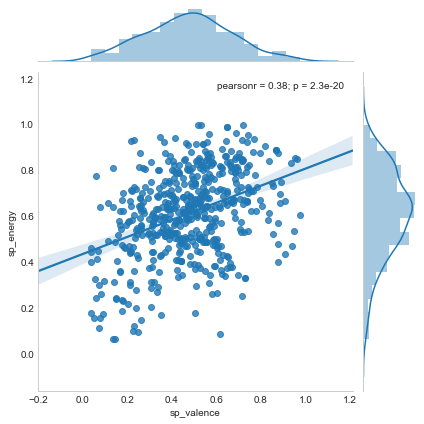

In [34]:
# create a dataframe with songs that are classified as peaceful by GN
df_fiery = df[df['gn_mood_1']=='Fiery']

# convert values to float
df_fiery_sp           = df_fiery
df_fiery_sp           = df_fiery_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_fiery_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_fiery_sp['sp_valence'].mean())
df_mean_values.loc['Fiery','mean_valence'] = df_fiery_sp['sp_valence'].mean()
df_mean_values.loc['Fiery','mean_energy'] = df_fiery_sp['sp_energy'].mean()
print("Energy mean: ", df_fiery_sp['sp_energy'].mean())
# ax.set_title("Fiery")

## Digging into Somber

Valence mean:  0.21128291366906465
Energy mean:  0.31308845323741014


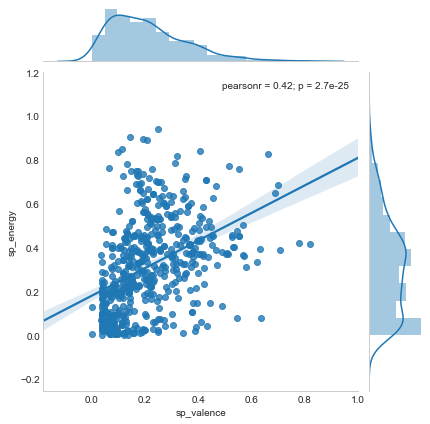

In [35]:
# create a dataframe with songs that are classified as peaceful by GN
df_somber = df[df['gn_mood_1']=='Somber']

# convert values to float
df_somber_sp            = df_somber
df_somber_sp           = df_somber_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_somber_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_somber_sp['sp_valence'].mean())
df_mean_values.loc['Somber','mean_valence'] = df_somber_sp['sp_valence'].mean()
df_mean_values.loc['Somber','mean_energy'] = df_somber_sp['sp_energy'].mean()
print("Energy mean: ", df_somber_sp['sp_energy'].mean())
# ax.set_title("Somber")

## Digging into Gritty

Valence mean:  0.4844936305732485
Energy mean:  0.46489872611464983


/Users/feelharmonic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/feelharmonic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


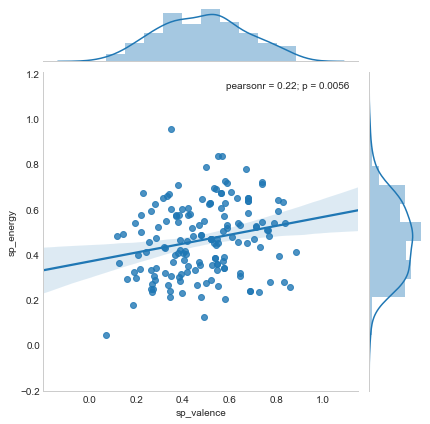

In [36]:
# create a dataframe with songs that are classified as peaceful by GN
df_gritty = df[df['gn_mood_1']=='Gritty']

# convert values to float
df_gritty_sp            = df_gritty
df_gritty_sp            = df_gritty_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_gritty_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_gritty_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_gritty_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_gritty_sp['sp_energy'].mean()
print("Energy mean: ", df_gritty_sp['sp_energy'].mean())
# ax.set_title("Gritty")

## Digging into Easygoing

Valence mean:  0.53212027027027
Energy mean:  0.41224256756756783


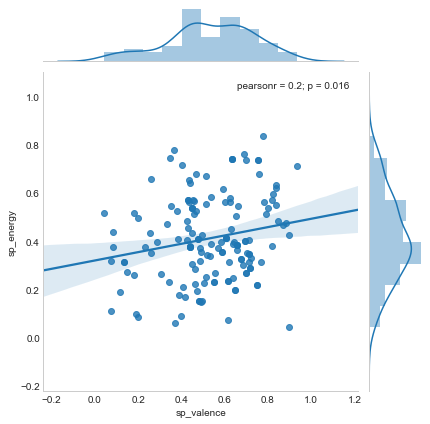

In [37]:
# create a dataframe with songs that are classified as peaceful by GN
df_easygoing = df[df['gn_mood_1']=='Easygoing']

# convert values to float
df_easygoing_sp            = df_easygoing
df_easygoing_sp            = df_easygoing_sp[['sp_valence', 'sp_energy']].astype('float64')

# plot
sns.jointplot(x='sp_valence', y='sp_energy', data=df_easygoing_sp, kind ='reg')
ax = plt.gca()
print("Valence mean: ", df_easygoing_sp['sp_valence'].mean())
df_mean_values['mean_valence']['Sensual'] = df_easygoing_sp['sp_valence'].mean()
df_mean_values['mean_energy']['Sensual'] = df_easygoing_sp['sp_energy'].mean()
print("Energy mean: ", df_easygoing_sp['sp_energy'].mean())
# ax.set_title("Easygoing")

## Clustering on gracenote data

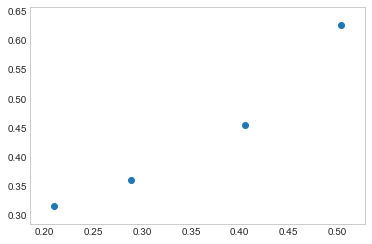

In [39]:
data_x = [0.28846, 0.405072, 0.503788, 0.20981]
data_y = [0.360690, 0.455012, 0.626872, 0.315459]
plt.scatter(data_x, data_y)
plt.xlabel
plt.legend()

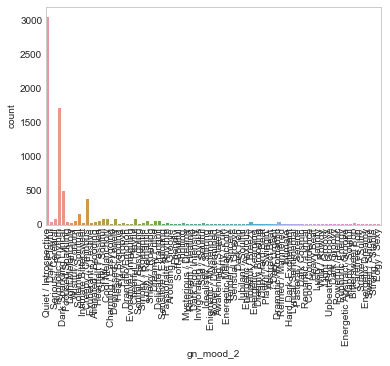

In [40]:
# Some moods are under-represented in the data compared to others
sns.countplot(df.gn_mood_2, orient = 'h')
plt.xticks(rotation=90);

In [41]:
con = get_db_handle()
#     print(con)
querystr = "select * from featuredb where gn_mood_1 like \'%Rowdy%\'"
#where name like \'%Shri%\'"
df_rowdy = query_db_translate_to_pandas(con, querystr)
print("Number of songs classified as rowdy are: \n", df_rowdy.count(axis=0)[0])

Number of songs classified as rowdy are: 
 17


In [42]:
con = get_db_handle()
querystr = "select * from featuredb where name like \'%Vrindavani%\' or name like \'%Brindabani%\' or name like \'%Sarang%\'"
#where name like \'%Shri%\'"
df_vrindavanisarang = query_db_translate_to_pandas(con, querystr)
print("Vrindavani Sarang: \n", df_vrindavanisarang.count(axis=0)[0])
print(df_vrindavanisarang.name.to_string())
print(df_vrindavanisarang.gn_mood_1)

Vrindavani Sarang: 
 117
0                                         Shuddha Sarang
1                                 Raga Brindabani Sarang
2                     Chaliye - Vrindavana Saranga - Adi
3                     Chaliye - Vrindavana Saranga - Adi
4        Rangapura Vihara - Vrindavana Saranga - Rupakam
5                     Raga Shudh Sarang: Alap in Teental
6                                      Brindabani Sarang
7                                  A Saranga Convergence
8      Jhaptal In 10 Beats / Raga Jhinjoti On Sarangi...
9      Taal Posta In 5 Beats / Raga Jhinjoti On Saran...
10     Raga Madhmad Sarang (Tarana in drut teental - ...
11     Taal Pancham Sawari In 15 Beats / Raga Asha Ma...
12       Relaxing Into Awareness - Rag Brindavani Sarang
13                Raga Brindavani Sarang - Alap - Ektaal
14                                     Brindabani sarang
15     Raga Shuddh Sarang - Drut Gat - Teentaal - Ins...
16                   Raga Shuddha Sarang: Alap In Ektaal
17    

In [43]:
print(df.shape)

(7115, 23)


In [44]:
numerical = ['sp_energy', 'sp_instrumentalness', 'sp_valence']
numerical_1 = ['sp_energy', 'sp_instrumentalness', 'sp_valence', 'sp_danceability', 'sp_loudness', 'sp_liveness',  'sp_tempo', 'sp_speechiness', 'sp_acousticness', 'sp_mode']
categorical = ['gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1', 'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3']

In [45]:
df1 = df[numerical_1]
print(df1.columns)
df2 = df1.astype('float64')
print(type(df2['sp_energy'][2]))

Index(['sp_energy', 'sp_instrumentalness', 'sp_valence', 'sp_danceability',
       'sp_loudness', 'sp_liveness', 'sp_tempo', 'sp_speechiness',
       'sp_acousticness', 'sp_mode'],
      dtype='object')
<class 'numpy.float64'>


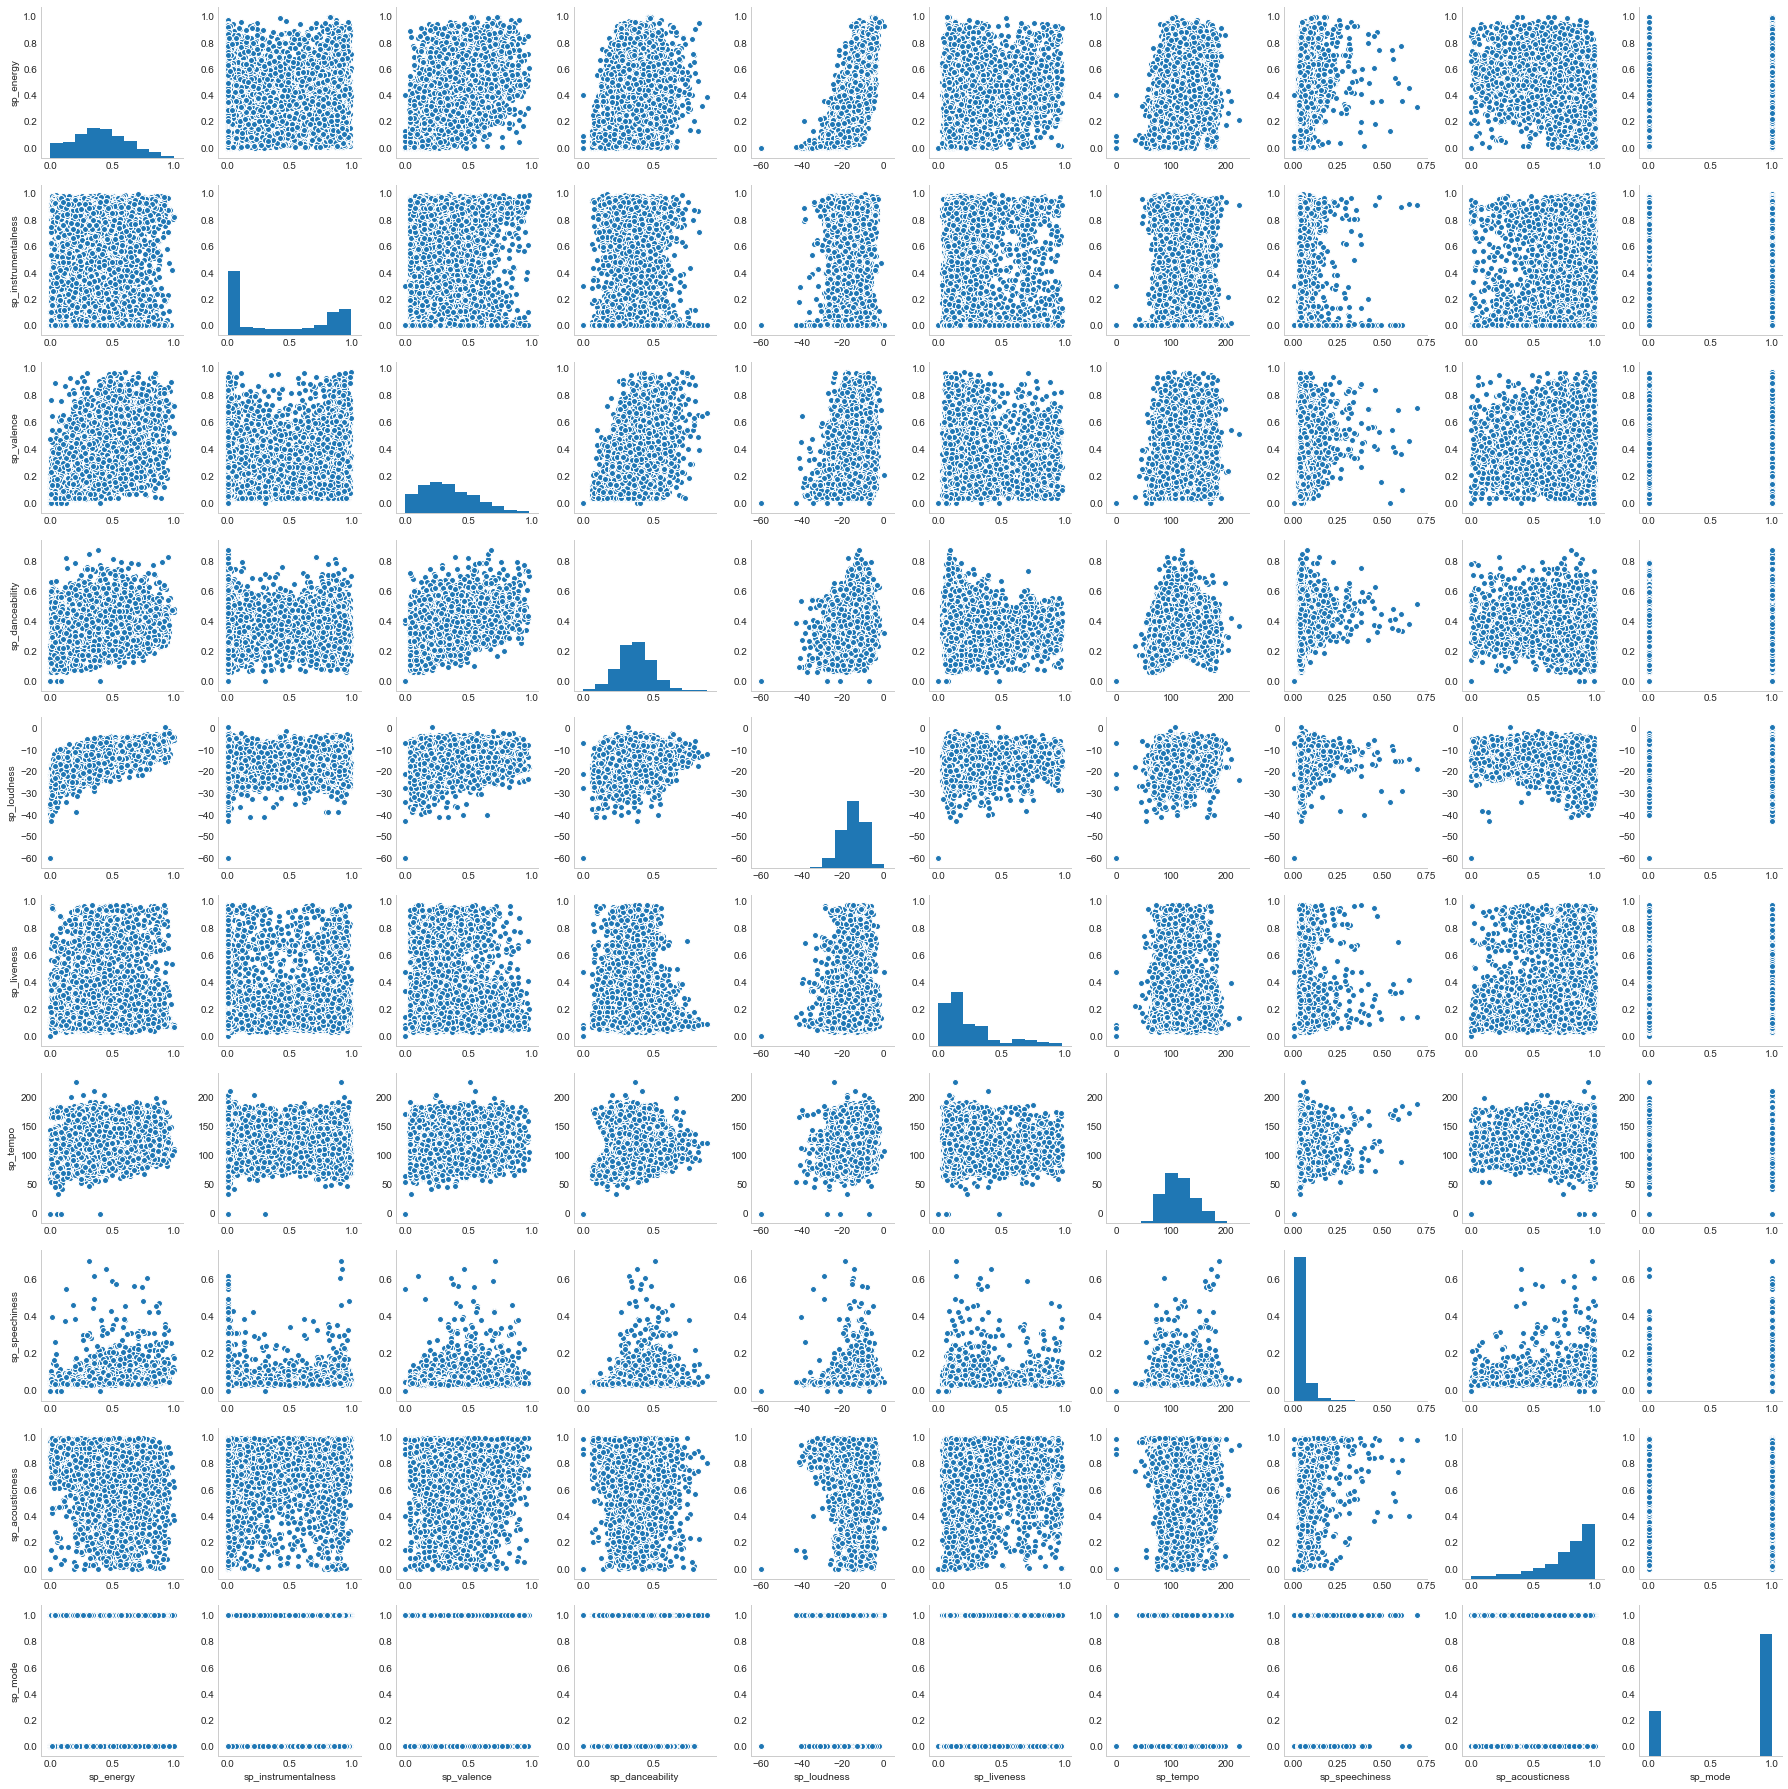

In [46]:
sns.pairplot(df2[numerical_1]) # plot univariate distribution

In [47]:
moods = list(df.gn_mood_1.unique())
print(moods)

['Peaceful', 'Sophisticated', 'Serious', 'Fiery', 'Stirring', 'Melancholy', 'Somber', 'Lively', 'Brooding', 'Romantic', 'Gritty', 'Sentimental', 'Easygoing', 'Defiant', 'Empowering', 'Upbeat', 'Sensual', 'Yearning', 'Energizing', 'Urgent', 'Tender', 'Aggressive', 'Cool', 'Rowdy', 'Excited']


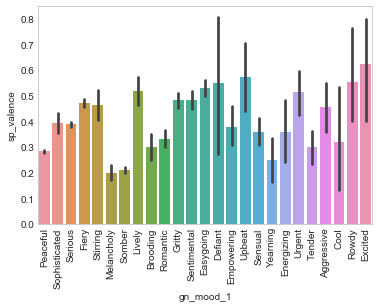

In [48]:
df[numerical_1] = df2[numerical_1]
sns.despine(left=True, bottom=True)
sns.barplot(x = 'gn_mood_1', y = 'sp_valence', data = df)
plt.xticks(rotation=90);


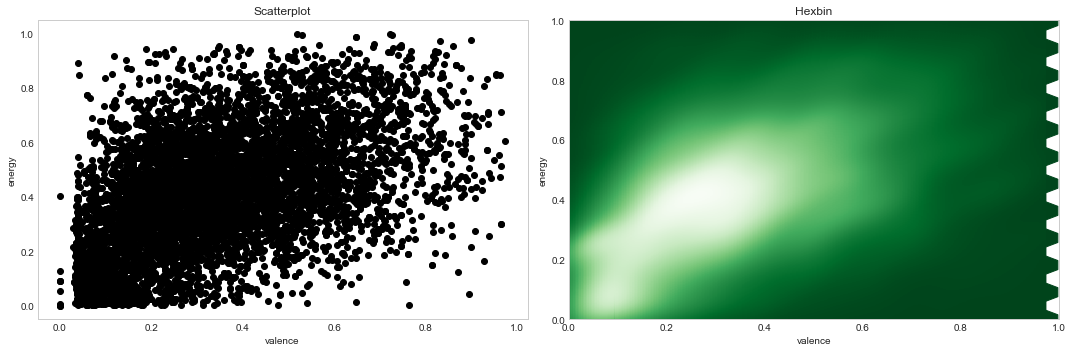

In [50]:
# create data
X = df.as_matrix(columns=["sp_valence", "sp_energy"])
x = X[:, 0]
y = X[:, 1]

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].set_xlabel('valence')
axes[0].set_ylabel('energy')
plt.legend()

# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko')

# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
axes[1].set_xlabel('valence')
axes[1].set_ylabel('energy')
plt.legend()

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
# axes[2].set_title('Density')
plt.xlabel('valence')
plt.ylabel('energy')
plt.legend()
axis_label = ['0.0','0.2','0.4','0.6','0.8','1.0']
plt.xticks( 1/5*np.arange(6), axis_label)
plt.yticks( 1/5*np.arange(6), axis_label)
plt.tight_layout()
# plt.savefig('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/IndianClassicalMusic/Week2/data_plot.jpg', dpi = 300)
plt.show()



In [51]:
# Close communication with the database
close_db(con)